In [1]:
# Run the notebook as if it's in the PROJECT directory
%bookmark PROJ_ROOT /reg/data/ana03/scratch/cwang31/pf
%cd -b PROJ_ROOT

(bookmark:PROJ_ROOT) -> /reg/data/ana03/scratch/cwang31/pf
/reg/data/ana03/scratch/cwang31/pf


In [2]:
# Load paths for using psana
%env SIT_ROOT=/reg/g/psdm/
%env SIT_DATA=/cds/group/psdm/data/
%env SIT_PSDM_DATA=/cds/data/psdm/

env: SIT_ROOT=/reg/g/psdm/
env: SIT_DATA=/cds/group/psdm/data/
env: SIT_PSDM_DATA=/cds/data/psdm/


In [3]:
import os
import torch
import random
import numpy as np
import h5py
import time

from peaknet.methods.unet       import UNet
from peaknet.model              import ConfigPeakFinderModel, PeakFinderModel
from peaknet.datasets.utils     import PsanaImg
from peaknet.datasets.transform import center_crop, coord_crop_to_img

from cupyx.scipy import ndimage
import cupy as cp

seed = 0

In [4]:
import matplotlib.pyplot as plt
import matplotlib.colors       as mcolors
import matplotlib.patches      as mpatches
import matplotlib.transforms   as mtransforms
%matplotlib inline

## Load psana for accessing image data

In [5]:
# Sample cspad dataset
exp           = 'cxic0415'
run           = 101
img_load_mode = 'calib'
access_mode   = 'idx'
detector_name = 'CxiDs1.0:Cspad.0'
photon_energy = 12688.890590380644    # eV
encoder_value = -450.0034

psana_img = PsanaImg(exp, run, access_mode, detector_name)

In [ ]:
# # Sample epix10k dataset
# exp           = 'mfxp22820'
# run           = 13
# img_load_mode = 'calib'
# access_mode   = 'idx'
# detector_name = 'Rayonix'
# photon_energy = 9.54e3    # eV
# encoder_value = -196

# psana_img = PsanaImg(exp, run, access_mode, detector_name)

## Load Model

In [10]:
timestamp = "2022_1101_2326_41"
fl_chkpt = None if timestamp is None else f"{timestamp}.train.chkpt"

In [8]:
base_channels = 8
focal_alpha   = 1.2
focal_gamma   = 2.0
method = UNet( in_channels = 1, out_channels = 1, base_channels = base_channels )
config_peakfinder = ConfigPeakFinderModel( method = method,  
                                           focal_alpha = focal_alpha,
                                           focal_gamma = focal_gamma)
model = PeakFinderModel(config_peakfinder)
model.init_params()    # ..., load random weights 

In [11]:
# model.init_params(from_timestamp = timestamp)   # Run this will load a trained model
model.init_params(fl_chkpt = fl_chkpt)   # Run this will load a trained model

In [12]:
# Load model to gpus if available...
device = torch.cuda.current_device() if torch.cuda.is_available() else 'cpu'
model  = model.method.to(device)

## Define hooks (Optional)

This is for for printing the metadata of the underlying neural networks.

In [ ]:
# Define hooks...
activation_dict = {}
preactivation_dict = {}
def get_activation(name, tag = ''):
    if tag not in preactivation_dict: preactivation_dict[tag] = {}
    if tag not in activation_dict: activation_dict[tag] = {}
    def hook(model, input, output):
        preactivation_dict[tag][name] = input
        activation_dict[tag][name] = output
    return hook

# Define what layer you want to check...
for name, layer in model.named_modules():
    if isinstance(layer, torch.nn.ReLU):
        layer.register_forward_hook(get_activation(name, 'relu'))

    if "final_conv" in name:
        layer.register_forward_hook(get_activation(name, 'final_conv'))

In [ ]:
# # Check out the shape of the output in each layer...
# class ReLUShapePrinter:
#     def __call__(self, module, input, output):
#         if isinstance(module, torch.nn.ReLU):
#             print(f"{module.__class__.__name__} output shape: {output.shape}")
            
# # Register the shape printer on each layer
# for name, module in model.named_modules():
#     module.register_forward_hook(ReLUShapePrinter())
            
# Check out the shape of the output in each layer...
class NonReLUShapePrinter:
    def __call__(self, module, input, output):
        if not isinstance(module, torch.nn.ReLU):
            print(f"{module.__class__.__name__} output shape: {output.shape}")

# Register the shape printer on each layer
for name, module in model.named_modules():
    module.register_forward_hook(NonReLUShapePrinter())

### Example of finding peaks in one image (access by event)

In [19]:
def apply_mask(data, mask):
    """
    Return masked data.

    Args:
        data: numpy.ndarray with the shape of (B, H, W). 
              - B: batch of images.
              - H: height of an image.
              - W: width of an image.

        mask: numpy.ndarray with the shape of (B, H, W). 

    Returns:
        data_masked: numpy.ndarray.
    """
    # Mask unwanted pixels with np.nan...
    data_masked = np.where(mask, data, np.nan)

    return data_masked


Elapsed: 5.7633728720247746 ms.


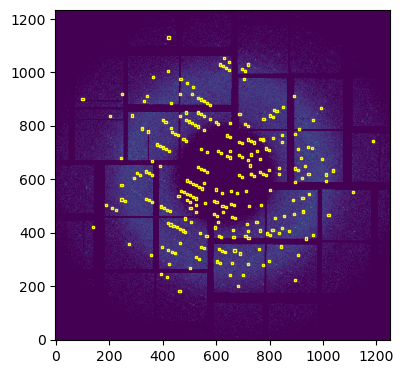

In [38]:
saves_plot = False

# Load images by event...
# event = 46
event = 5458
multipanel_mask       = psana_img.create_bad_pixel_mask()
multipanel_img        = psana_img.get(event, None, 'calib')
multipanel_img_masked = multipanel_mask * multipanel_img

img = psana_img.assemble(multipanel_img_masked)

# img = remove_outliers(img)
offset = 250
# offset = 0
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
img = img[ymin:ymax, xmin:xmax]
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 1 - 1e-4
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (4.679,4.29))
gspec = fig.add_gridspec( nrows, ncols,
                          # width_ratios  = [1, 1/20],
                          # height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1),  ]

# Plot image
data = img_crop
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)

# ax_list[0].set_xticks([])
# ax_list[0].set_yticks([])

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

Elapsed: 4.014311823993921 ms.


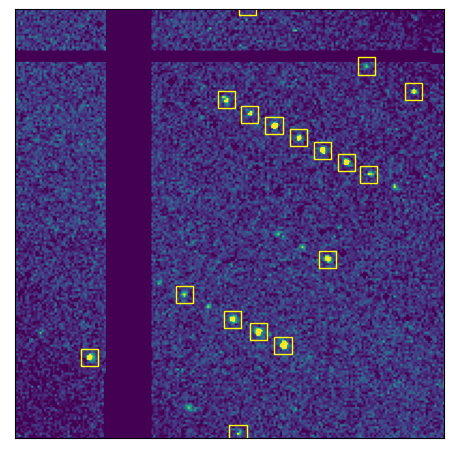

In [39]:
saves_plot = True

# Load images by event...
# event = 46
event = 5458
multipanel_mask       = psana_img.create_bad_pixel_mask()
multipanel_img        = psana_img.get(event, None, 'calib')
multipanel_img_masked = multipanel_mask * multipanel_img

img = psana_img.assemble(multipanel_img_masked)

# img = remove_outliers(img)
offset = 250
# offset = 0
size_y, size_x = img.shape
xmin = 0 + offset
xmax = size_x - offset
ymin = 0 + offset
ymax = size_y - offset
img = img[ymin:ymax, xmin:xmax]
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 1 - 1e-4
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (4.679,4.29))
gspec = fig.add_gridspec( nrows, ncols,
                          # width_ratios  = [1, 1/20],
                          # height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1),  ]

# Plot image
data = img_crop
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)

cy, cx = 380, 420
win_size = 100
size_y, size_x = img_crop.shape[-2:]
xmin = cx - win_size
xmax = cx + win_size
ymin = cy - win_size
ymax = cy + win_size
ax_list[0].set_xlim([xmin, xmax])
ax_list[0].set_ylim([ymin, ymax])

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    # ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    # ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.zoom0.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)

In [ ]:
saves_plot = True

# Load images by event...
# event = 46
event = 5458
multipanel_mask       = psana_img.create_bad_pixel_mask()
multipanel_img        = psana_img.get(event, None, 'calib')
multipanel_img_masked = multipanel_mask * multipanel_img

img = psana_img.assemble(multipanel_img_masked)

# img = remove_outliers(img)
cy, cx = 600, 700
win_size = 100
size_y, size_x = img.shape
xmin = cx - win_size
xmax = cx + win_size
ymin = cy - win_size
ymax = cy + win_size
img = img[ymin:ymax, xmin:xmax]
img = torch.tensor(img).type(dtype=torch.float)[None,None,].to(device)
img = (img - img.mean()) / img.std()

model.eval()
time_start = time.monotonic()
with torch.no_grad():
    fmap = model.forward(img)
mask_predicted = fmap.sigmoid()
time_end = time.monotonic()
print(f"Elapsed: {(time_end - time_start) * 1e3} ms.")

threshold_prob = 1 - 1e-4
mask_predicted[  mask_predicted < threshold_prob ] = 0
mask_predicted[~(mask_predicted < threshold_prob)] = 1

# Crop the original image...
size_y, size_x = mask_predicted.shape[-2:]
img_crop, offset_tuple = center_crop(img, size_y, size_x, returns_offset_tuple = True)

img_crop       = img_crop[0, 0].cpu().detach().numpy()
mask_predicted = mask_predicted[0, 0].cpu().detach().numpy()


# Locate peaks with coordinates...
structure = np.ones((3, 3), dtype=bool)
peak_predicted, num_peak_predicted = ndimage.label(cp.asarray(mask_predicted), structure)
peak_pos_predicted_list = ndimage.center_of_mass(cp.asarray(mask_predicted), peak_predicted, cp.asarray(range(1, num_peak_predicted+1)))

# [[[ Visual ]]]
# Set up the visual
ncols = 1
nrows = 1
fig   = plt.figure(figsize = (4.679,4.29))
gspec = fig.add_gridspec( nrows, ncols,
                          # width_ratios  = [1, 1/20],
                          # height_ratios = [1,], 
                        )
ax_list = [ fig.add_subplot(gspec[0, 0], aspect = 1),  ]

# Plot image
data = img_crop
vmin = np.mean(data) - 0 * data.std()
vmax = np.mean(data) + 6 * data.std()
im = ax_list[0].imshow(data, vmin = vmin, vmax = vmax)

ax_list[0].set_xticks([])
ax_list[0].set_yticks([])

# Place a box on a peak
offset = 4
b_offset = 2
for y, x in peak_pos_predicted_list:
    if np.isnan(y) or np.isnan(x): continue

    x_bottom_left = x.get() - offset
    y_bottom_left = y.get() - offset

    rec_obj = mpatches.Rectangle((x_bottom_left, y_bottom_left), 
                                 2 * offset, 2 * offset, 
                                 linewidth = 1.0, 
                                 edgecolor = 'yellow', 
                                 facecolor='none')
    ax_list[0].add_patch(rec_obj)

    y_bmin, x_bmin = 0, 0
    y_bmax, x_bmax = size_y, size_x
    ax_list[0].set_xlim([x_bmin - b_offset, x_bmax + b_offset])
    ax_list[0].set_ylim([y_bmin - b_offset, y_bmax + b_offset])

if saves_plot:
    drc_pdf  = "figures.paper"
    fl_pdf   = f"predict.{exp}.run{run}.event{event}.zoom0.pdf"
    path_pdf = os.path.join(drc_pdf, fl_pdf)
    fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.1, hspace=0)
    fig.savefig(path_pdf, dpi = 300)